In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Daten laden

In [2]:
y_st =  pd.read_excel(r"C:\Users\NSTANZ\OneDrive - Wiener Stadtwerke\ELSA\InnoChallenge\Analytik\GNN001\Y-Stationen_2Jahre.xlsx").set_index('Unnamed: 0')
#y_st =  pd.read_excel(r"C:\Users\NSTANZ\OneDrive - Wiener Stadtwerke\ELSA\InnoChallenge\Analytik\GPN010\GPN010_2017bis20.xlsx").set_index('Unnamed: 0')

# Main Analysis

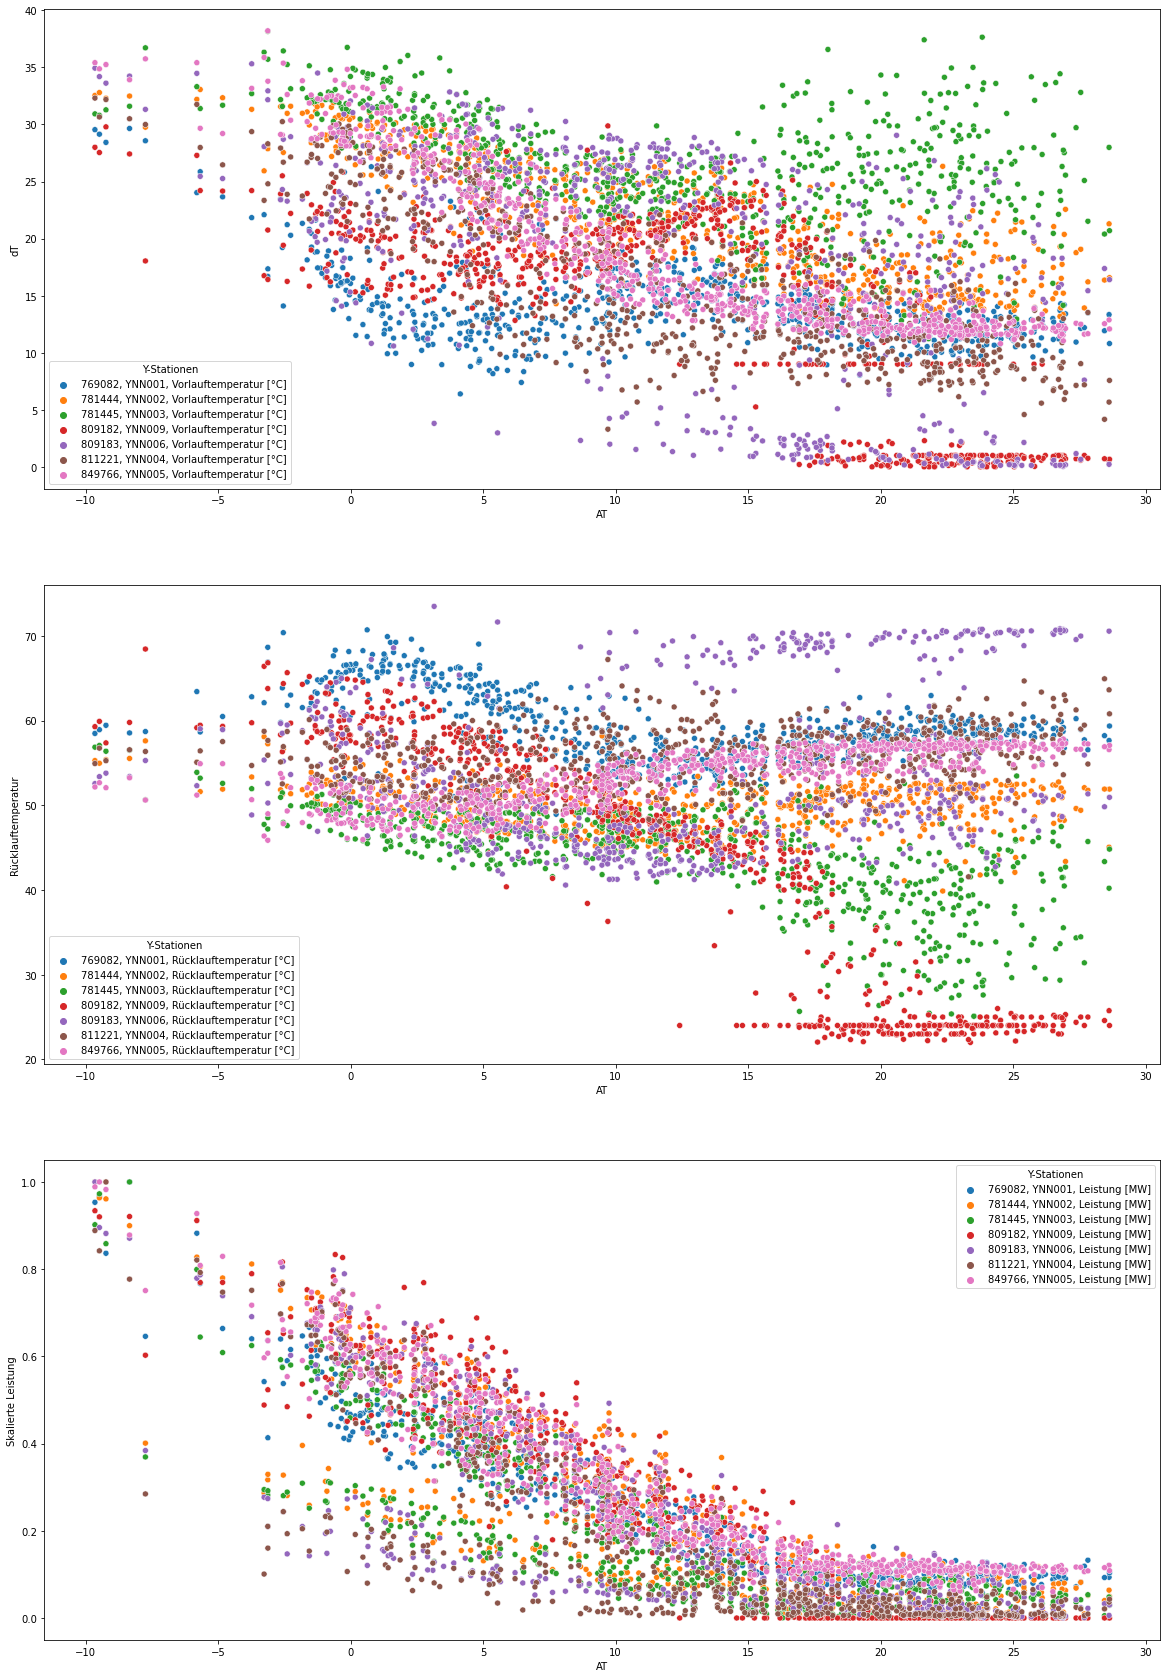

In [3]:
## Berechnung der Tagesmittelwerte ##
y_st['Tagesauflösung'] = y_st.index
y_st['Tagesauflösung'] = pd.to_datetime(y_st['Tagesauflösung']).dt.date
y_st_day = y_st.groupby(by=["Tagesauflösung"]).mean()

## RÜCKLAUFTEMPERATUR ##
y_ges_RLT = y_st_day.filter(like = 'Rücklauftemperatur').copy()
y_ges_RLT['AT'] = y_st_day.filter(like = 'AT')
y_ges_RLT = y_ges_RLT.melt('AT', var_name = 'Y-Stationen', value_name = 'Rücklauftemperatur')

## WÄRMESTROM ##
y_ges_Q = y_st_day.filter(like = 'Leistung')/y_st_day.filter(like = 'Leistung').max()
y_ges_Q['AT'] = y_st_day.filter(like = 'AT')
y_ges_Q = y_ges_Q.melt('AT', var_name = 'Y-Stationen', value_name = 'Skalierte Leistung')

## DELTA T ##
y_ges_VLT = y_st_day.filter(like = 'Vorlauftemperatur').copy()
y_ges_VLT['AT'] = y_st_day.filter(like = 'AT')
y_ges_VLT = y_ges_VLT.melt('AT', var_name = 'Y-Stationen', value_name = 'dT')

y_ges_dT = y_ges_VLT
y_ges_dT['dT'] = y_ges_VLT['dT'] - y_ges_RLT['Rücklauftemperatur']

## PLOTS ## 
fig, ax = plt.subplots(3,1, figsize = (20,30))
sns.scatterplot(ax = ax[0], x = 'AT', y = 'dT',  hue = 'Y-Stationen', data = y_ges_dT)
sns.scatterplot(ax = ax[1], x = 'AT', y = 'Rücklauftemperatur',  hue = 'Y-Stationen', data = y_ges_RLT)
sns.scatterplot(ax = ax[2], x = 'AT', y = 'Skalierte Leistung',  hue = 'Y-Stationen', data = y_ges_Q)

plt.show()


# Referenzstation finden
Als Referenzstationen werden die top 25% bezüglich druchschnittlicher Rücklauftemperatur verwendet

In [4]:
## Stationen mit geringster Rücklauftemperatur ##
top = y_st_day[y_st_day['111003, , Amtliche AT (ZAMG - Urheberrecht beachten) [°C]'] < 15].filter(like=('Rücklauftemperatur')).mean()

## Die besten 25% als Referenzstationen ##
x = round(len(top)*0.25) 
top = list(top.sort_values().index[0:x])

ref = []
for i in top:
    ref.append(i.split(',')[1])   

# Berechnung Overflow

In [16]:
def overflow(y_st_day):
    
    ## Bestimmung der Konstanten ##
    roh = 997.04 #[Kg/m3] bei 
    cp = 4179.6 #[J/Kg K] bei 25°C
    dT_ideal = 45 #[°C]

    ## Berechnung V_ideal ##

    Q_real = y_st_day.filter(like ='Leistung')
    V_real = y_st_day.filter(like='Durchfluß')
    q_ideal = roh * cp/1000000 * dT_ideal * (1/3600)

    V_ideal = Q_real/q_ideal
    V_ideal.columns = V_real.columns
    overflow = V_real - V_ideal

    return overflow.mean()

overflow(y_st_day)

769082, YNN001, Durchfluß [m3h]      6.973855
781444, YNN002, Durchfluß [m3h]      3.066248
781445, YNN003, Durchfluß [m3h]      2.944402
809182, YNN009, Durchfluß [m3/h]     0.545562
809183, YNN006, Durchfluß [m3/h]    10.266436
811221, YNN004, Durchfluß [m3/h]     4.795898
849766, YNN005, Durchfluß [m3/h]     1.046192
dtype: float64

# Regression
Breakingpoint bei -2°C

### Temperaturdifferenz

In [6]:
def linreg_dT(y, breakpoint):
    
    y_ges_RLT = pd.DataFrame(columns = y, index = y_st_day.index, dtype=float)
    y_ges_dT = pd.DataFrame(columns = y, index = y_st_day.index, dtype=float)
    y_ges_VLT =  pd.DataFrame(columns = y, index = y_st_day.index, dtype=float)
    #breakpoint = -2
    
    for s in y:
    
        ## RÜCKLAUFTEMPERATUR ##
        y_ges_RLT[s] = y_st_day.filter(like = 'Rücklauftemperatur').filter(like = s).copy()
        y_ges_RLT['AT'] = y_st_day.filter(like = 'AT')
        
        ## DELTA T ##
        y_ges_VLT[s] = y_st_day.filter(like = 'Vorlauftemperatur').filter(like = s).copy()
        y_ges_VLT['AT'] = y_st_day.filter(like = 'AT')
        
       
    ## Umformen und Berechnung dT ##
    y_ges_RLT = y_ges_RLT.melt('AT', var_name = 'Y-Stationen', value_name = 'Rücklauftemperatur')
    y_ges_VLT = y_ges_VLT.melt('AT', var_name = 'Y-Stationen', value_name = 'dT')

    ## -2 bis 15°C ##
    y_ges_dT_1 = y_ges_VLT[(y_ges_VLT['AT'] < 15) & (y_ges_VLT['AT'] > breakpoint)].copy()
    y_ges_dT_1['dT'] = y_ges_VLT['dT'] - y_ges_RLT['Rücklauftemperatur']
    
    ## unter -2°C ##
    y_ges_dT_2 = y_ges_VLT[(y_ges_VLT['AT'] < breakpoint)].copy()
    y_ges_dT_2['dT'] = y_ges_VLT['dT'] - y_ges_RLT['Rücklauftemperatur']
    
    ## Regression ##
    result_1 = stats.linregress(y_ges_dT_1['AT'],y_ges_dT_1['dT'])
    result_2 = stats.linregress(y_ges_dT_2['AT'],y_ges_dT_2['dT'])
    
    
    return result_1.slope, result_1.intercept, np.std(y_ges_dT_1['dT']), result_2.slope, result_2.intercept, np.std(y_ges_dT_2['dT'])

    
linreg_dT(ref, -2)
    

(-0.605835157120772,
 30.295529328157706,
 3.896044685158301,
 0.015842327111827186,
 32.24031874105393,
 2.584089643075231)

### Wärmeleistung

In [7]:
def linreg_Q(y):
    
    y_ges_Q = pd.DataFrame(columns = y, index = y_st_day.index, dtype=float)
    
    for s in y:
    
        ## WÄRMESTROM ##
        y_ges_Q[s] = (y_st_day.filter(like = 'Leistung')/ y_st_day.filter(like = 'Leistung').max()).filter(like = s).copy()
        y_ges_Q['AT'] = y_st_day.filter(like = 'AT')
       
    ## Umformen und Berücksichtigung bis 15°C ##
    y_ges_Q = y_ges_Q.melt('AT', var_name = 'Y-Stationen', value_name = 'Leistung')
    y_ges_Q = y_ges_Q[y_ges_Q['AT'] < 15]
    
    ## Regression ##
    result = stats.linregress(y_ges_Q['AT'],y_ges_Q['Leistung'])
    
    #print('y =',result.slope,'* x +', result.intercept)
    
    return result.slope, result.intercept, np.std(y_ges_Q['Leistung'])
    

linreg_Q(ref) 

(-0.028454130963850695, 0.49747759387343216, 0.1931054459094271)

### Rücklauftemperatur
-> Überprüfen, ob Regression Sinn macht, oder konstanter Wert besser passen würde

In [8]:
def linreg_RLT(y):
    
    y_ges_RLT = pd.DataFrame(columns = y, index = y_st_day.index, dtype=float)
    
    for s in y:
    
        ## RLT ##
        y_ges_RLT[s] = y_st_day.filter(like = 'Rücklauftemperatur').filter(like = s).copy()
        y_ges_RLT['AT'] = y_st_day.filter(like = 'AT')
       
    ## Umformen und Berücksichtigung bis 15°C ##
    y_ges_RLT = y_ges_RLT.melt('AT', var_name = 'Y-Stationen', value_name = 'Rücklauftemperatur')
    y_ges_RLT = y_ges_RLT[y_ges_RLT['AT'] < 15]
    
    ## Regression ##
    result = stats.linregress(y_ges_RLT['AT'],y_ges_RLT['Rücklauftemperatur'])
    
    #print('y =',result.slope,'* x +', result.intercept)
    
    return result.slope, result.intercept, np.std(y_ges_RLT['Rücklauftemperatur'])

linreg_RLT(ref)

(-0.2485688022500334, 49.871078928878674, 2.860177705856738)

# Outlier
Für RLT-Outlier muss noch ein Schwellwert definiert werden (Konstante?)

### Temperaturdifferenz

In [9]:
def outlier_dT(y):
    
    part1 = pd.DataFrame(dtype=float, index = y_st_day.index)
    part2 = pd.DataFrame(dtype=float, index = y_st_day.index)
    
    breakpoint = -2
    
    ## Refernzstationen ##
    #ref = ['YNN009','YNN005']
    
    ## breakpoint bis 15°C ##
    k1 = linreg_dT(ref, breakpoint)[0]
    d1 = linreg_dT(ref, breakpoint)[1]
    err1 = linreg_dT(ref, breakpoint)[2]
    
    part1['AT'] =  y_st_day[(y_st_day['111003, , Amtliche AT (ZAMG - Urheberrecht beachten) [°C]'] < 15) & (y_st_day['111003, , Amtliche AT (ZAMG - Urheberrecht beachten) [°C]'] > breakpoint)].filter(like = 'AT').copy()
    part1['RLT'] =  y_st_day[(y_st_day['111003, , Amtliche AT (ZAMG - Urheberrecht beachten) [°C]'] < 15) & (y_st_day['111003, , Amtliche AT (ZAMG - Urheberrecht beachten) [°C]'] > breakpoint)].filter(like = 'Rücklauftemperatur').filter(like = y).copy()
    part1['VLT'] =  y_st_day[(y_st_day['111003, , Amtliche AT (ZAMG - Urheberrecht beachten) [°C]'] < 15) & (y_st_day['111003, , Amtliche AT (ZAMG - Urheberrecht beachten) [°C]'] > breakpoint)].filter(like = 'Vorlauftemperatur').filter(like = y).copy()
    part1['dT'] = part1['VLT'] - part1['RLT']
    
    part1['lower'] = k1 * part1['AT'] + (d1 - err1)
    part1['outlier'] = (part1['dT'] < part1['lower'])
    
    ## unter breakpoint ##
    k2 = linreg_dT(ref, breakpoint)[3]
    d2 = linreg_dT(ref, breakpoint)[4]
    err2 = linreg_dT(ref, breakpoint)[5]
    
    part2['AT'] =y_st_day[y_st_day['111003, , Amtliche AT (ZAMG - Urheberrecht beachten) [°C]'] < breakpoint ].filter(like = 'AT').copy()
    part2['RLT'] = y_st_day[y_st_day['111003, , Amtliche AT (ZAMG - Urheberrecht beachten) [°C]'] < breakpoint ].filter(like = 'Rücklauftemperatur').filter(like = y).copy()
    part2['VLT'] = y_st_day[y_st_day['111003, , Amtliche AT (ZAMG - Urheberrecht beachten) [°C]'] < breakpoint ].filter(like = 'Vorlauftemperatur').filter(like = y).copy()
    part2['dT'] = part2['VLT'] - part2['RLT']
    
    part2['lower'] = k2 * part2['AT'] + (d2 - err2)
    
    ## Outlier ##
    #station['outlier'] = ((station['dT'] < station['lower']) | (station['dT'] > station['upper']))
    part2['outlier'] = (part2['dT'] < part2['lower'])
    
    return part1['outlier'].sum() + part2['outlier'].sum()


In [10]:
def outlier_Q(y):
    
    station = pd.DataFrame(dtype=float, index = y_st_day.index)
    
    ## Refernzstationen ##
    #ref = ['YNN009','YNN005']
    k = linreg_Q(ref)[0]
    d = linreg_Q(ref)[1]
    err = linreg_Q(ref)[2]
    
    station['AT'] = y_st_day.filter(like = 'AT').copy()
    station['Leistung'] = (y_st_day[y_st_day['111003, , Amtliche AT (ZAMG - Urheberrecht beachten) [°C]'] < 15 ].filter(like = 'Leistung')/ y_st_day.filter(like = 'Leistung').max()).filter(like = y).copy()
    
    ## Grenzen Standardabweichung ##
    station['lower'] = k * station['AT'] + (d - err)
    station['upper'] = k * station['AT'] + (d + err)
    
    ## Outlier ##
    station['outlier'] = ((station['Leistung'] < station['lower']) | (station['Leistung'] > station['upper']))

    
    return station['outlier'].sum()

### Rücklauftemperatur

In [11]:
def outlier_RLT_reg(y):
    
    station = pd.DataFrame(dtype=float, index = y_st_day.index)
    
    ## Refernzstationen ##
    #ref = ['YNN009','YNN005']
    k = linreg_RLT(ref)[0]
    d = linreg_RLT(ref)[1]
    err = linreg_RLT(ref)[2]
    
    station['AT'] = y_st_day.filter(like = 'AT').copy()
    station['RLT'] = y_st_day[y_st_day['111003, , Amtliche AT (ZAMG - Urheberrecht beachten) [°C]'] < 15 ].filter(like = 'Rücklauftemperatur').filter(like = y).copy()
    
    ## Grenzen Standardabweichung ##
    station['lower'] = k * station['AT'] + (d - err)
    station['upper'] = k * station['AT'] + (d + err)
    
    ## Outlier ##
    station['outlier'] = ((station['RLT'] < station['lower']) | (station['RLT'] > station['upper']))

    
    return station['outlier'].sum()

In [12]:
def outlier_RLT_konst(y):
    
    station = pd.DataFrame(dtype=float, index = y_st_day.index)
    
    station['AT'] = y_st_day.filter(like = 'AT').copy()
    station['RLT'] = y_st_day[y_st_day['111003, , Amtliche AT (ZAMG - Urheberrecht beachten) [°C]'] < 100 ].filter(like = 'Rücklauftemperatur').filter(like = y).copy()
    
    ## Schwellwert ##
    Tgr = 55
    
    ## Outlier ##
    station['outlier'] = (station['RLT'] > Tgr)

    
    return station['outlier'].sum()

# Ergebnisfunktion

In [13]:
def ergliste():
    ## Namen der Stationen finden ##
    stationen = []
    for i in y_st.columns[1:-1]:
        stationen.append(i.split(',')[1])
    stationen = sorted(list(set(stationen)))

    ## Ergebnisliste erstellen ##
    erg = pd.DataFrame(columns = stationen, index = ['Outliers dT', 'Outliers RLT', 'Outliers Q', 'Overflow [m3/h]'])

    ## Befüllen der Liste ##
    for y in stationen:
        erg.loc['Outliers dT', y] = outlier_dT(y)
        erg.loc['Outliers RLT',y] = outlier_RLT_konst(y)
        erg.loc['Outliers Q',y] = outlier_Q(y)
        erg.loc['Overflow [m3/h]',y] = overflow(y_st_day).filter(like = y)[0]

    erg = erg.sort_values(by = 'Overflow [m3/h]', axis = 1, ascending = False)
    
    return erg

ergliste()

,YNN006,YNN001,YNN004,YNN002,YNN003,YNN005,YNN009
Outliers dT,131,401,306,57,1,220,296
Outliers RLT,240,616,415,14,4,268,179
Outliers Q,87,6,83,60,40,31,62
Overflow [m3/h],10.2664,6.97385,4.7959,3.06625,2.9444,1.04619,0.545562


# Ergebnisdarstellung

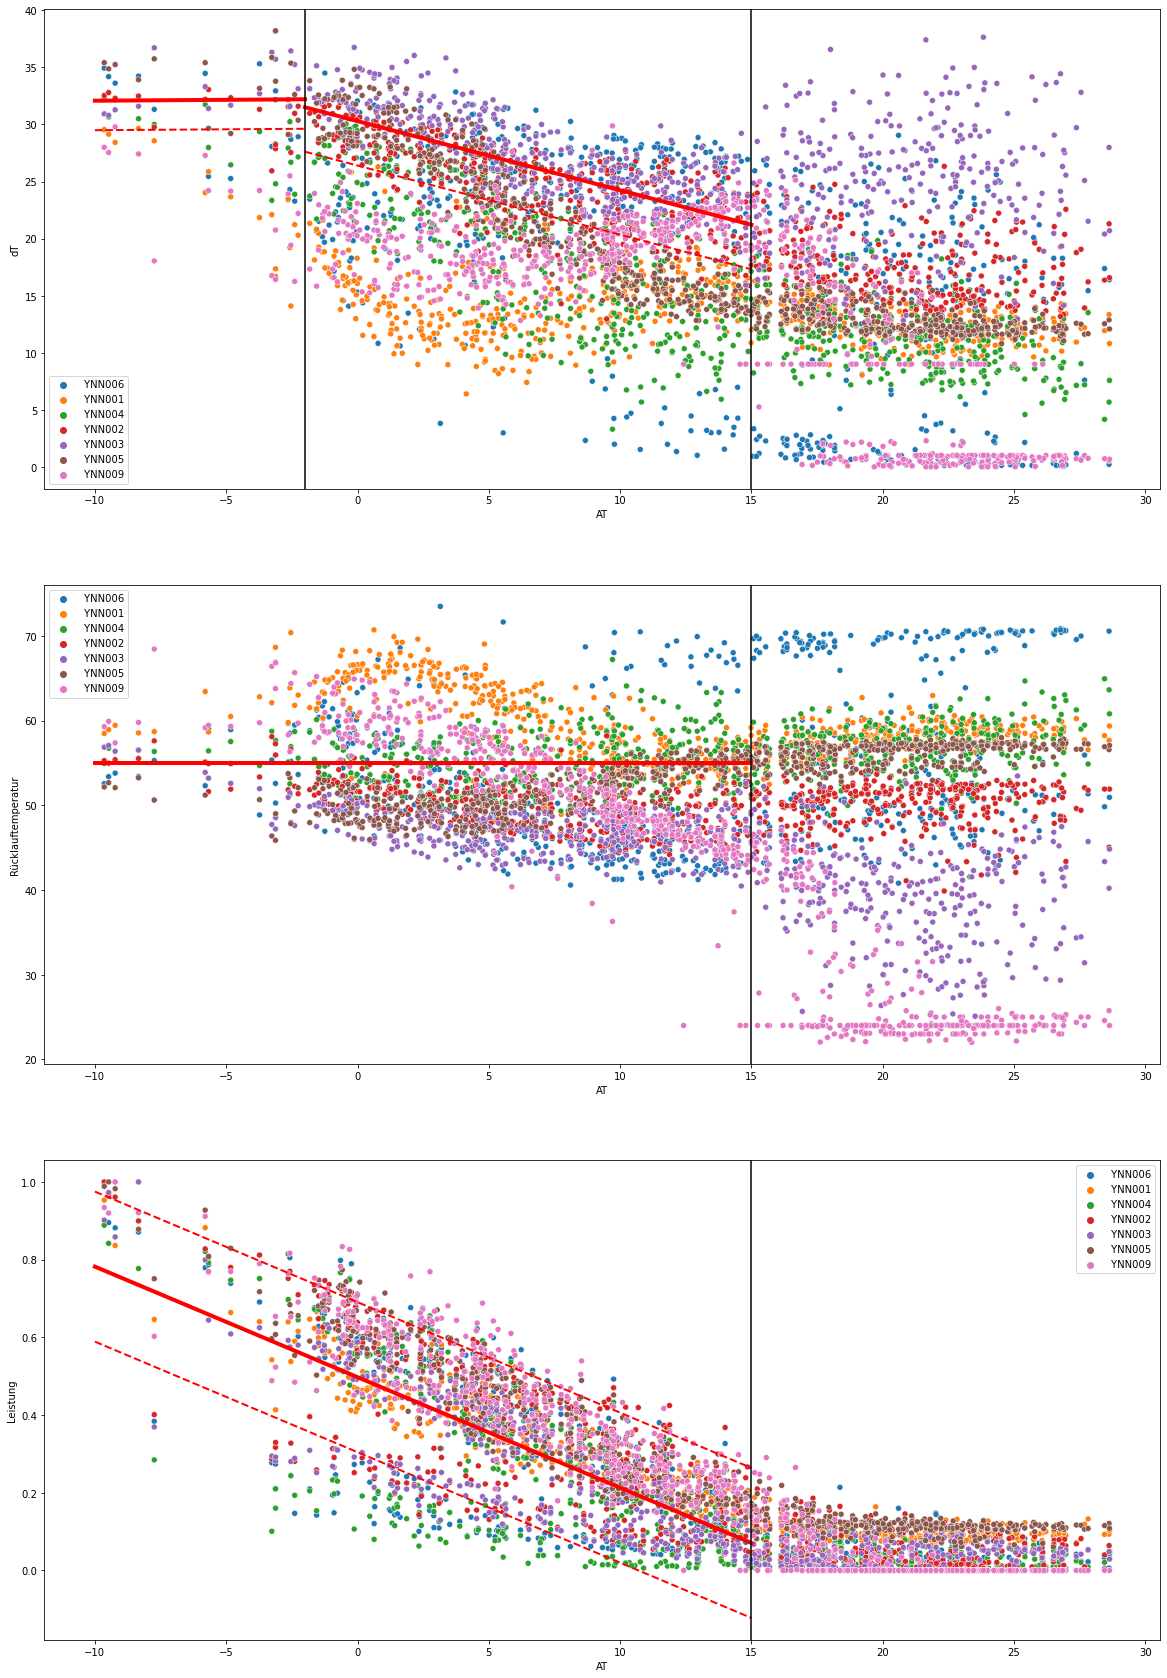

In [14]:
def darstellung(y):
    
    y_ges_Q = pd.DataFrame(columns = y, index = y_st_day.index, dtype=float)
    y_ges_RLT = pd.DataFrame(columns = y, index = y_st_day.index, dtype=float)
    y_ges_dT = pd.DataFrame(columns = y, index = y_st_day.index, dtype=float)
    y_ges_VLT =  pd.DataFrame(columns = y, index = y_st_day.index, dtype=float)
    breakpoint = -2
    
    for s in y:
        
        ## RÜCKLAUFTEMPERATUR ##
        y_ges_RLT[s] = y_st_day.filter(like = 'Rücklauftemperatur').filter(like = s).copy()
        y_ges_RLT['AT'] = y_st_day.filter(like = 'AT')
        
        ## DELTA T ##
        y_ges_VLT[s] = y_st_day.filter(like = 'Vorlauftemperatur').filter(like = s).copy()
        y_ges_VLT['AT'] = y_st_day.filter(like = 'AT')
        y_ges_dT[s] = y_ges_VLT[s] - y_ges_RLT[s]
        y_ges_dT['AT'] = y_st_day.filter(like = 'AT')
        
        ## Q ##
        y_ges_Q[s] = (y_st_day.filter(like = 'Leistung')/ y_st_day.filter(like = 'Leistung').max()).filter(like = s).copy()
        y_ges_Q['AT'] = y_st_day.filter(like = 'AT')
        
    y_ges_Q = y_ges_Q.melt('AT', var_name = 'Y-Stationen', value_name = 'Leistung')
    y_ges_RLT = y_ges_RLT.melt('AT', var_name = 'Y-Stationen', value_name = 'Rücklauftemperatur')
    y_ges_VLT = y_ges_VLT.melt('AT', var_name = 'Y-Stationen', value_name = 'dT')
    y_ges_dT = y_ges_dT.melt('AT', var_name = 'Y-Stationen', value_name = 'dT')
    
    
    fig, ax = plt.subplots(3,1, figsize = (20,30))
    sns.scatterplot(ax = ax[0], x = 'AT', y = 'dT',  hue = 'Y-Stationen', data = y_ges_dT)
    sns.scatterplot(ax = ax[1], x = 'AT', y = 'Rücklauftemperatur',  hue = 'Y-Stationen', data = y_ges_RLT)
    sns.scatterplot(ax = ax[2], x = 'AT', y = 'Leistung',  hue = 'Y-Stationen', data = y_ges_Q) 
    
    ## Regression ##
    
    # dT
    x1 = np.linspace(-10,-2)
    k1 = linreg_dT(ref, breakpoint)[3]
    d1 = linreg_dT(ref, breakpoint)[4]
    err1 = linreg_dT(ref, breakpoint)[5]

    x2 = np.linspace(-2, 15)
    k2 = linreg_dT(ref, breakpoint)[0]
    d2 = linreg_dT(ref, breakpoint)[1]
    err2 = linreg_dT(ref, breakpoint)[2]

    sns.lineplot(ax = ax[0], x = x1, y = k1*x1+d1, linewidth = 4, color = 'r')
    sns.lineplot(ax = ax[0], x = x1, y = k1*x1+(d1-err1), linewidth = 2, color = 'r', linestyle='--')
    sns.lineplot(ax = ax[0], x = x2, y = k2*x2+d2, linewidth = 4, color = 'r')
    sns.lineplot(ax = ax[0], x = x2, y = k2*x2+(d2- err2), linewidth = 2, color = 'r', linestyle='--')
    ax[0].axvline(breakpoint, 0, 40, color ='black')
    ax[0].axvline(15, 0, 40, color ='black')

    #RLT
    x3 = np.linspace(-10,15)
    y3 = 55

    sns.lineplot(ax=ax[1], x = x3, y = y3, linewidth = 4, color = 'r')
    ax[1].axvline(15, 0, 40, color ='black')
    
    #Q
    k4 = linreg_Q(ref)[0]
    d4 = linreg_Q(ref)[1]
    err4 = linreg_Q(ref)[2]
    
    sns.lineplot(ax=ax[2], x = x3, y = k4*x3+d4, linewidth = 4, color = 'r')
    sns.lineplot(ax=ax[2], x = x3, y = k4*x3+(d4-err4), linewidth = 2, color = 'r', linestyle = '--')
    sns.lineplot(ax=ax[2], x = x3, y = k4*x3+(d4+err4), linewidth = 2, color = 'r', linestyle = '--')
    ax[2].axvline(15, 0, 40, color ='black')
    
    
    return plt.show()

darstellung(ergliste().columns)